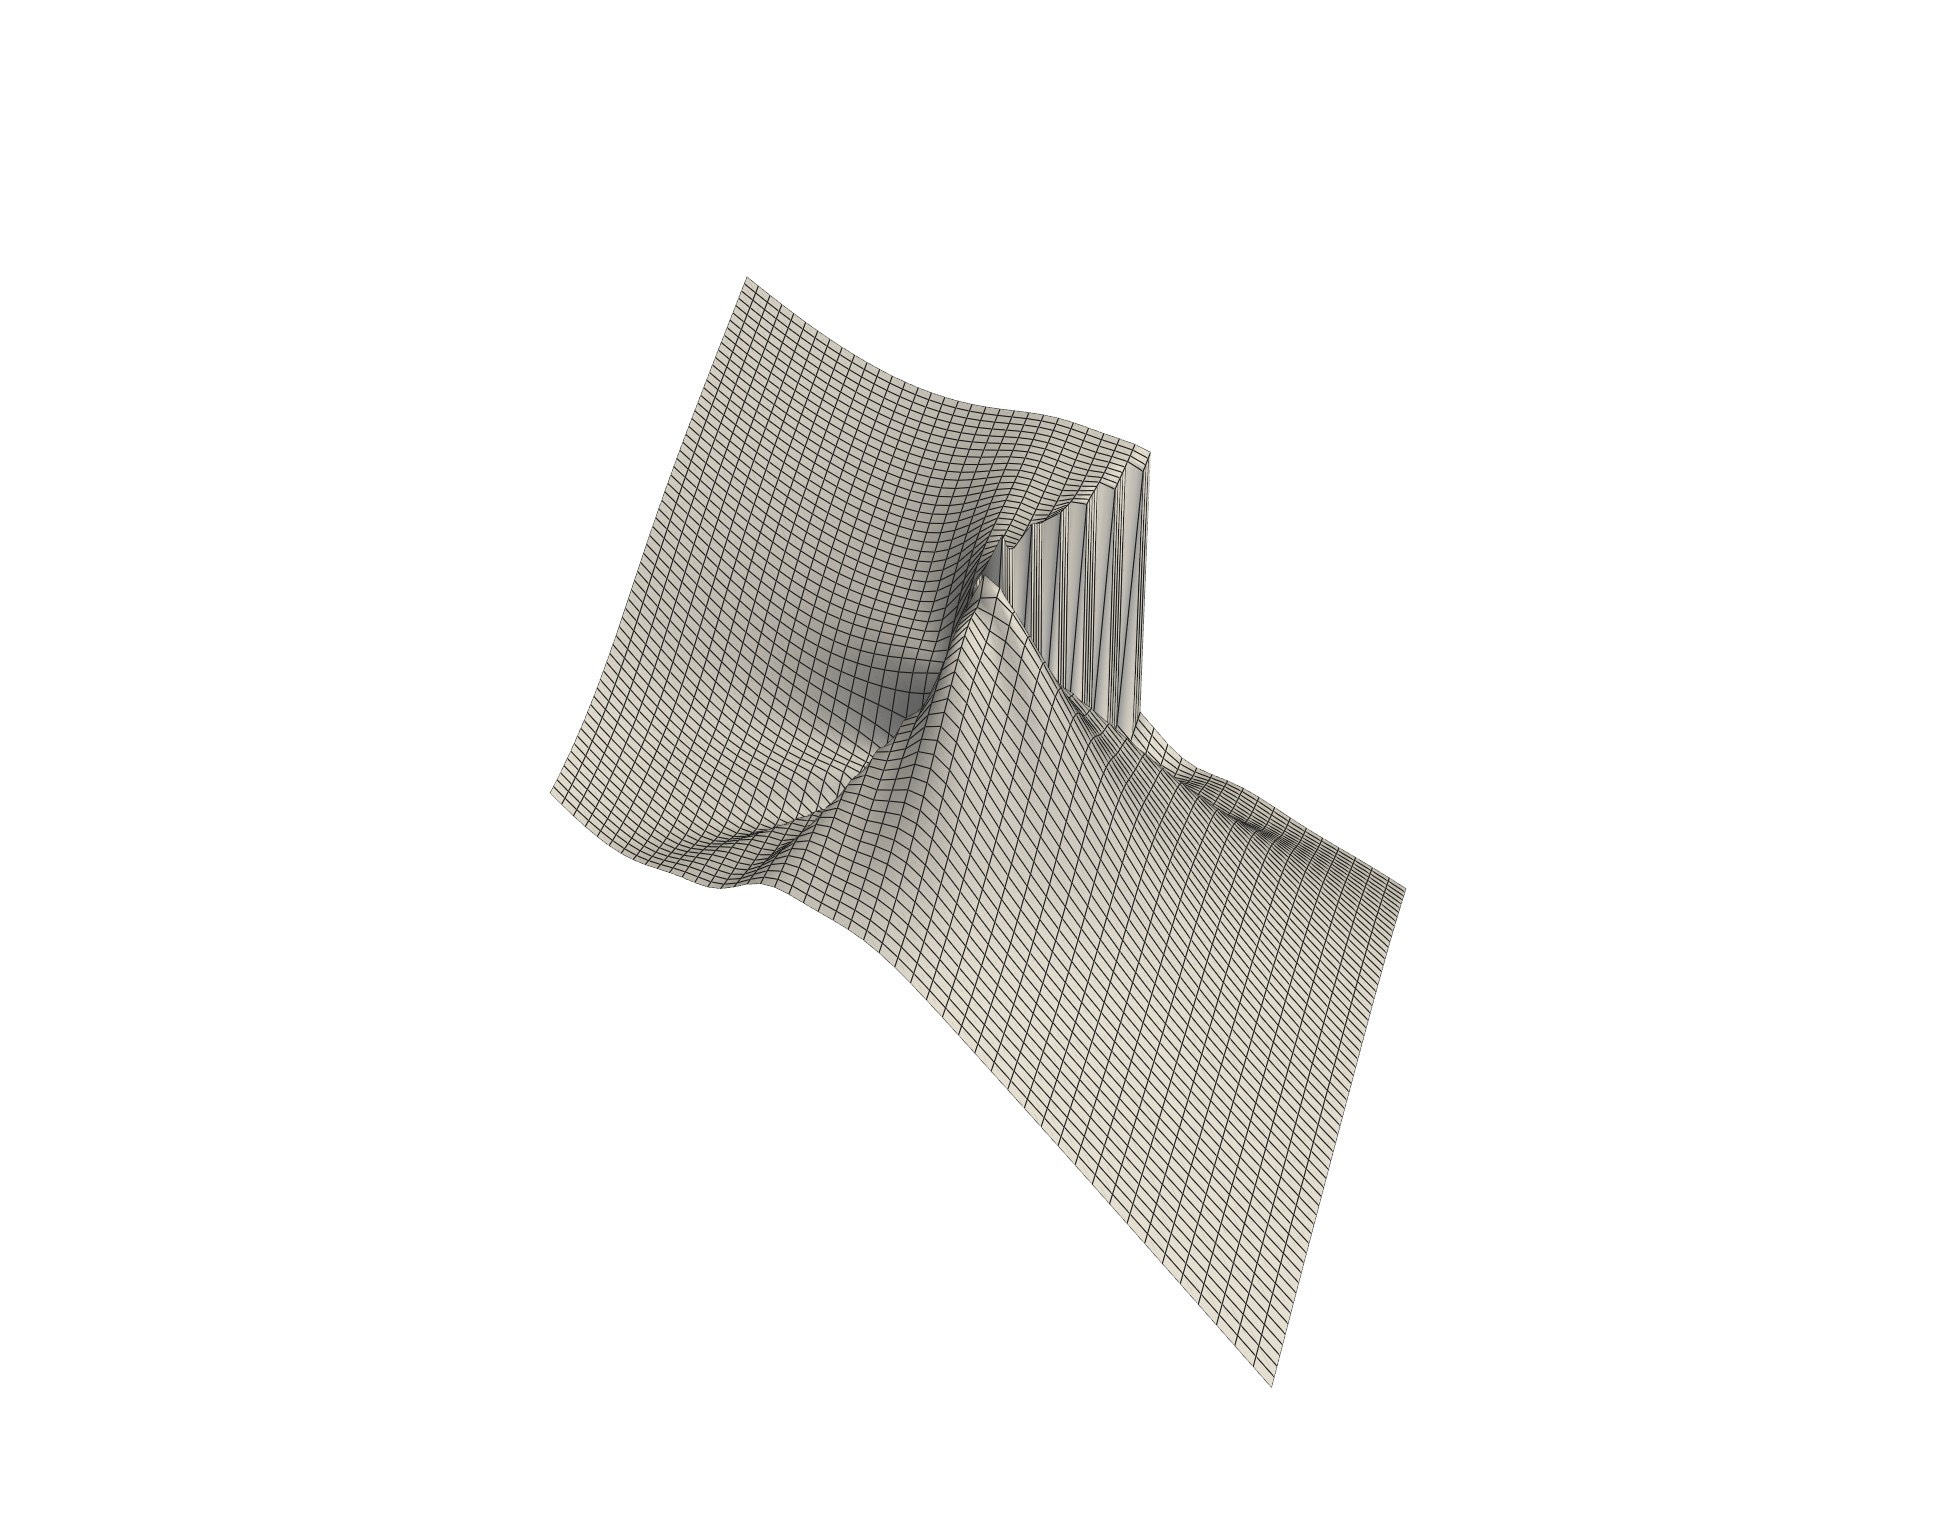

In [ ]:
import numpy as np
import pyvista as pv
import pyvistaqt # needed for VS Code interactive window

pv.set_plot_theme("document")

# ============================================================
# More complex vault — upgraded parameters
# ============================================================

# Bigger scale
radius = 16.0 # 原本 5，增加到 3x
height = 7.5 # 垂直高度增加

# Much denser mesh = more complex details
res_u = 64 # → 解析度加倍
res_v = 48

# Rhombus control
shear = 0.75
angle = 28
scale_uv = (1.0, 1.35) # 拉伸比例（越非均向越建築）

# Extra deformation strength
petal_freq = 10
petal_amp = height * 0.12 # 比原始更強

# Twisting amplitude
twist_strength = 0.55

# Wave modulation
wave_amp = height * 0.18
wave_freq = 4.2

# ============================================================
# Parametric domain
# ============================================================

u_lin = np.linspace(-1.0, 1.0, res_u + 1)
v_lin = np.linspace(-1.0, 1.0, res_v + 1)
U, V = np.meshgrid(u_lin, v_lin, indexing='xy')

U *= scale_uv[0]
V *= scale_uv[1]

# Rhombus shear
U_s = U + shear * V
V_s = V

# Rotation
theta = np.deg2rad(angle)
cos_t, sin_t = np.cos(theta), np.sin(theta)
U_r = cos_t * U_s - sin_t * V_s
V_r = sin_t * U_s + cos_t * V_s

# Scale into XY world
X = U_r * radius
Y = V_r * radius

# ============================================================
# Height functions (multi-layer mixed)
# ============================================================

# Base — smooth dome
Z1 = height * np.exp(-(X**2 + Y**2) / (2 * (radius * 0.55)**2))

# Secondary catenary ribs
a = radius * 0.8
cat = a * (np.cosh(X / a) - 1.0)
cat_norm = (cat - cat.min()) / (cat.max() - cat.min() + 1e-9)
rib_ridge = cat_norm * np.exp(-(Y**2) / (2 * (radius * 0.75)**2))
Z2 = rib_ridge * (height * 0.5)

# Radial twisting (angle field)
angle_field = np.arctan2(Y, X)
Z3 = twist_strength * radius * np.sin(1.5 * angle_field)

# Wave-like wrinkles
R = np.sqrt(X**2 + Y**2)
Z4 = wave_amp * np.sin(wave_freq * (U + V * 0.7)) * np.exp(-(R / radius)**1.2)

# Flower-petal modulation
Z5 = petal_amp * np.cos(petal_freq * angle_field) * np.exp(-(R / (radius * 0.8))**2)

# Combined height
Z = Z1 + Z2 + Z3 + Z4 + Z5

# ============================================================
# Build mesh
# ============================================================

grid = pv.StructuredGrid(X, Y, Z)
shell = grid.extract_surface()

# ============================================================
# Display
# ============================================================

plotter = pv.Plotter(window_size=(1300, 900))
plotter.add_mesh(
shell,
color="#f6f6f6",
smooth_shading=True,
show_edges=True,
edge_color="#1a1a1a",
line_width=1.0
)

plotter.add_axes(line_width=2)
plotter.camera_position = "iso"

plotter.show()